In [1]:
# CELL 1: Setup Environment, Clone Repo (with PAT), Override Paths (Updated & Complete)

# --- 1. Basic Setup & Environment ---
print("Setting up environment...")
import os
import sys
import gc
from pathlib import Path
import warnings
import json # Needed for handling kaggle.json secret
import subprocess

warnings.filterwarnings('ignore')

# --- PREPARE KAGGLE API KEY ---
# Define expected location for kaggle api key
KAGGLE_CONFIG_DIR = Path('/root/.kaggle')
KAGGLE_JSON_TARGET_PATH = KAGGLE_CONFIG_DIR / 'kaggle.json'
KAGGLE_SECRET_LABEL = "KAGGLE_KEY" # <<< MUST MATCH the secret label you created

print(f"Checking/Setting up Kaggle API key at {KAGGLE_JSON_TARGET_PATH}...")
kaggle_api_ready = False
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    kaggle_key_content = user_secrets.get_secret(KAGGLE_SECRET_LABEL)
    KAGGLE_CONFIG_DIR.mkdir(parents=True, exist_ok=True)
    with open(KAGGLE_JSON_TARGET_PATH, 'w') as f: f.write(kaggle_key_content)
    os.chmod(KAGGLE_JSON_TARGET_PATH, 0o600)
    print("Kaggle API key successfully copied from Secrets.")
    kaggle_api_ready = True
except FileNotFoundError: print(f"WARNING: Secret '{KAGGLE_SECRET_LABEL}' not found. Kaggle API features might fail.")
except Exception as e: print(f"WARNING: Could not setup Kaggle API key: {e}")
# --- END KAGGLE API KEY SETUP ---


# --- Install Dependencies ---
print("Installing specific dependency versions...")
!pip install -q --upgrade pip
!pip install -q ml-dtypes~=0.4.0
!pip install -q tensorboard~=2.17.0

print("Installing main packages...")
ACCELERATOR_TYPE = "GPU" # <<< CHANGE TO "GPU" IF GPU IS ENABLED
TF_PACKAGE = "tensorflow-cpu==2.17.1" if ACCELERATOR_TYPE == "CPU" else "tensorflow==2.17.1"
!pip install -q pyarrow joblib seaborn matplotlib tqdm scikit-learn {TF_PACKAGE}

print("Checking/Installing Kaggle CLI...")
# Corrected Kaggle CLI Installation Logic in Cell 1

# Check/Install Kaggle CLI (now safe as key should be present if using secrets)
print("Checking/Installing Kaggle CLI...")
kaggle_cli_installed = False
try:
    import kaggle
    print("Kaggle CLI already installed.")
    kaggle_cli_installed = True
except ImportError:
    print("Kaggle CLI not found, attempting installation...")
    # Run install command using ! on its own line
    !pip install -q kaggle

    # Try importing again AFTER installation attempt
    try:
        import kaggle
        print("Kaggle CLI installed and imported successfully.")
        kaggle_cli_installed = True
    except ImportError:
        print("ERROR: Failed to import Kaggle CLI even after installation attempt.")
        # Depending on whether download is needed, you might stop here
        # if SHOULD_DOWNLOAD: assert False, "Kaggle CLI required but failed to install/import"
    except Exception as e_inner:
         print(f"An error occurred importing Kaggle CLI after install: {e_inner}")

except Exception as e_outer:
    print(f"An error occurred during Kaggle CLI check: {e_outer}")

# Optional: Check if installation succeeded if it was attempted
# if not kaggle_cli_installed:
#    print("WARNING: Kaggle CLI might not be properly installed.")

# --- Continue with cloning GitHub repo ---
print("Cloning repository using PAT from Secrets...")
# ... rest of the cell ...


# --- 2. Clone Your GitHub Repo (Using PAT from Secrets) ---
print("Cloning repository using PAT from Secrets...")
# Secrets Labels used
GIT_USER_SECRET = "GITHUB_USER"
GIT_TOKEN_SECRET = "GITHUB_TOKEN"
# Your Repo Details
GIT_REPO = "march-mania-2025v3"  # <<< Your Repo Name

REPO_PATH_STR = f"/kaggle/working/{GIT_REPO}"
REPO_PATH = Path(REPO_PATH_STR)

# Get secrets for GitHub
try:
    if 'user_secrets' not in locals(): from kaggle_secrets import UserSecretsClient; user_secrets = UserSecretsClient() # Ensure client exists
    GIT_USERNAME = user_secrets.get_secret(GIT_USER_SECRET)
    GIT_TOKEN = user_secrets.get_secret(GIT_TOKEN_SECRET)
    secrets_loaded = True
except Exception as e:
    print(f"ERROR: Could not retrieve GitHub secrets ('{GIT_USER_SECRET}', '{GIT_TOKEN_SECRET}'): {e}")
    secrets_loaded = False
    assert False, "Failed to get GitHub secrets" # Stop execution

if secrets_loaded:
    # Check if the directory exists and remove it
    if REPO_PATH.exists() and REPO_PATH.is_dir():
        print(f"Removing existing repository directory: {REPO_PATH_STR}")
        rm_return_code = os.system(f"rm -rf '{REPO_PATH_STR}'")
        if rm_return_code == 0: print("Directory removed successfully.")
        else: print(f"Warning: Failed to remove directory (Code: {rm_return_code}).")

    # Construct authenticated URL
    clone_url = f"https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPO}.git"
    print(f"Cloning from authenticated URL into {REPO_PATH_STR}")
    clone_result = subprocess.run(["git", "clone", "--depth", "1", clone_url, REPO_PATH_STR], capture_output=True, text=True)

    if clone_result.returncode != 0:
        print(f"ERROR: Git clone failed!")
        print(f"Stderr: {clone_result.stderr}")
        assert False, "Git clone failed"
    else:
        print("Repository cloned successfully.")

    # Change current working directory
    if REPO_PATH.exists() and REPO_PATH.is_dir():
        %cd {REPO_PATH_STR}
        print(f"Changed directory to: {os.getcwd()}")
    else:
        print(f"ERROR: Repository directory {REPO_PATH_STR} not found after clone attempt.")
        assert False, "Failed to change directory after clone"
# --- End Clone ---


# --- 3. Install Specific Requirements (Optional) ---
print("Skipping requirements.txt installation.")


# --- 4. Add Source Code to Python Path ---
if Path.cwd() == REPO_PATH: # Check CWD before modifying path
    sys.path.insert(0, str(REPO_PATH))
    sys.path.insert(0, str(REPO_PATH / 'src'))
    print(f"Added to sys.path: {str(REPO_PATH)}, {str(REPO_PATH / 'src')}")
else:
    print("ERROR: Not in expected repo directory. Path not updated.")
    assert False, "Incorrect working directory"


# --- 5. Import Config and Utils ---
print("Importing config and utils...")
config_imported = False
try:
    import config
    from src.utils import logger, seed_everything
    print("Config and utils imported successfully.")
    config_imported = True
except Exception as e: print(f"ERROR during import: {e}")


# --- 6. Override Paths for Kaggle Environment ---
if config_imported:
    print("Overriding directory paths for Kaggle environment...")
    try:
        KAGGLE_INPUT_DIR = Path(f'/kaggle/input/{config.COMPETITION_NAME}')
        KAGGLE_WORKING_DIR = Path('/kaggle/working')
        if KAGGLE_INPUT_DIR.exists() and any(KAGGLE_INPUT_DIR.iterdir()): config.RAW_DATA_DIR = KAGGLE_INPUT_DIR; print(f"RAW_DATA_DIR -> Kaggle Input: {config.RAW_DATA_DIR}"); SHOULD_DOWNLOAD = False
        else: config.RAW_DATA_DIR = KAGGLE_WORKING_DIR / "data" / "raw"; print(f"RAW_DATA_DIR -> Working Dir: {config.RAW_DATA_DIR}"); config.RAW_DATA_DIR.mkdir(parents=True, exist_ok=True); SHOULD_DOWNLOAD = True
        config.PROCESSED_DATA_DIR = KAGGLE_WORKING_DIR / "processed"; config.MODELS_DIR = KAGGLE_WORKING_DIR / "models"; config.SUBMISSIONS_DIR = KAGGLE_WORKING_DIR / "submissions"; config.VIZ_PATH = KAGGLE_WORKING_DIR / "visualizations"
        config.DATA_CACHE_FILE = config.PROCESSED_DATA_DIR / "data_cache.pkl"; config.TEAM_STATS_FILE = config.PROCESSED_DATA_DIR / "team_stats_per_season.parquet"; config.TRAIN_DATA_FILE = config.PROCESSED_DATA_DIR / "training_matchups.parquet"; config.TEST_DATA_FILE = config.PROCESSED_DATA_DIR / f"{config.CURRENT_SEASON}_prediction_matchups.parquet"
        kaggle_sub_base = Path(config.FINAL_SUBMISSION_FILE).stem.replace('_tf_v1','') + "_kaggle" # Make name more distinct
        config.FINAL_SUBMISSION_FILE = kaggle_sub_base + ".csv"; config.OOF_PREDS_FILE = config.PROCESSED_DATA_DIR / f"oof_{kaggle_sub_base}_predictions.csv"; config.SCALER_FILE = config.MODELS_DIR / f"scaler_{kaggle_sub_base}.joblib"
        print("Creating Kaggle output directories..."); config.PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True); config.MODELS_DIR.mkdir(parents=True, exist_ok=True); config.SUBMISSIONS_DIR.mkdir(parents=True, exist_ok=True); config.VIZ_PATH.mkdir(parents=True, exist_ok=True)
        seed_everything(); logger.info("===== Kaggle Notebook Setup Complete ====="); print(f"Final Submission Filename: {config.FINAL_SUBMISSION_FILE}")
    except AttributeError as e: print(f"ERROR: Missing variable in config: {e}"); config_imported = False
    except Exception as e: print(f"ERROR during path override: {e}"); config_imported = False
else: print("Skipping path overriding due to import errors.")

gc.collect()
print("-" * 50)
if config_imported: print("Setup finished. Proceed to the next cell to load data.")
else: print("Setup failed. Please check errors and configuration.")
print("-" * 50)

Setting up environment...
Checking/Setting up Kaggle API key at /root/.kaggle/kaggle.json...
Kaggle API key successfully copied from Secrets.
Installing specific dependency versions...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.6 MB/s eta 0:00:00
Installing main packages...
Checking/Installing Kaggle CLI...
Checking/Installing Kaggle CLI...
Kaggle CLI already installed.
Cloning repository using PAT from Secrets...
Cloning repository using PAT from Secrets...
Cloning from authenticated URL into /kaggle/working/march-mania-2025v3
Repository cloned successfully.
/kaggle/working/march-mania-2025v3
Changed directory to: /kaggle/working/march-mania-2025v3
Skipping requirements.txt installation.
Added to sys.path: /kaggle/working/march-mania-2025v3, /kaggle/working/march-mania-2025v3/src
Importing config and utils...
Config and utils imported successfully.
Overriding directory paths for Kaggle environment...
RAW_DATA_DIR -> Kaggle Input: /kaggle/input/march-machine-learning-man

# March Madness 2025 Prediction - TensorFlow Baseline (v1)

This notebook implements an end-to-end pipeline for the [Kaggle March Machine Learning Mania 2025](https://www.kaggle.com/competitions/march-machine-learning-mania-2025) competition.

**Goal:** Predict the probability of Team A beating Team B for all possible matchups in the 2025 NCAA Men's and Women's Division I Basketball Tournaments. Submissions are evaluated using the **Brier Score**.

**Approach:**

1.  **Data Loading:** Load historical game results, team details, seeds, etc. using the competition data. Includes automatic download via Kaggle API if data is not found in the input directory.
2.  **Feature Engineering:** Calculate team-level statistics per season, including basic stats (PPG, Win%), advanced efficiency metrics (OffEff, DefEff, NetEff per possession), Dean Oliver's Four Factors (eFG%, TOV%, ORB%, FTRate), and recent momentum (Last 10 games). Create matchup features based on the *difference* between opposing teams' stats.
3.  **Modeling:** Train a TensorFlow Sequential Neural Network using 5-Fold GroupKFold cross-validation (grouped by Season to prevent leakage).
4.  **Evaluation:** Primarily track the Out-of-Fold (OOF) Brier score.
5.  **Prediction:** Generate predictions for all possible 2025 matchups and create the submission file.

**Libraries:** Pandas, NumPy, TensorFlow/Keras, Scikit-learn, Joblib, Matplotlib, Seaborn, Tqdm, Kaggle API.

**(Cell 3: Code - Run Stage 1: Load Data)**
*Your code cell calling `load_raw_data`*

**(Cell 4: Markdown - Data Overview)**

```markdown
## 1. Data Loading & Overview

The `load_raw_data` function handles loading all necessary CSV files, downloading via the Kaggle API if needed, and caching the results for faster subsequent runs. It also performs basic integrity checks.

*   **Key Datasets Loaded:** M/W Teams, Seasons, Seeds, Compact Results (Regular & Tourney), Detailed Results (Regular & Tourney). (Optional: Ordinals, Coaches - check logs if loaded).
*   *(Optional: Add df.head() outputs or df.info() summaries for 1-2 key dataframes like MRegularSeasonDetailedResults here if desired)*

```markdown
## 1. Data Loading & Overview

The `load_raw_data` function handles loading all necessary CSV files, downloading via the Kaggle API if needed, and caching the results for faster subsequent runs. It also performs basic integrity checks.

*   **Key Datasets Loaded:** M/W Teams, Seasons, Seeds, Compact Results (Regular & Tourney), Detailed Results (Regular & Tourney). (Optional: Ordinals, Coaches - check logs if loaded).
*   *(Optional: Add df.head() outputs or df.info() summaries for 1-2 key dataframes like MRegularSeasonDetailedResults here if desired)*

In [2]:
# === Stage 1: Load Raw Data ===
import time
if config_imported: # Only run if setup was okay
    from src.data_loader import load_raw_data
    from src.utils import logger

    logger.info("\n===== Stage 1: Load Raw Data (Kaggle) =====")
    stage_start = time.time()
    # Use reload=True first time on Kaggle maybe, then False for cache
    # download_if_missing should be True if RAW_DATA_DIR is in /kaggle/working
    should_download = "/kaggle/working" in str(config.RAW_DATA_DIR)
    raw_data = load_raw_data(reload=False, download_if_missing=should_download, use_cache=True)
    if not raw_data:
        logger.error("STOPPING: Failed to load raw data.")
        # Stop execution if data loading fails
        assert False, "Failed to load raw data."
    else:
        logger.info(f"Stage 1 completed in {time.time() - stage_start:.2f} seconds.")
        print(f"Loaded {len(raw_data)} datasets.")
        gc.collect()
else:
    print("Skipping Stage 1 due to setup errors.")

Loading CSV files:   0%|          | 0/16 [00:00<?, ?file/s]

Loaded 14 datasets.


## 2. Feature Engineering

This stage calculates team statistics for each season and then creates matchup features based on the differences between opponents.

**A. Team Statistics per Season (`team_stats_per_season.parquet`):**
For each team and season (Men's and Women's separately, using data from `DATA_START_YEAR` onwards):
*   **Basic Stats:** Games Played, Win Percentage, Points Per Game (Scored, Allowed, Difference).
*   **Efficiency Metrics (Avg per Season):**
    *   `AvgOffEff`: Offensive Efficiency (Points per 100 possessions).
    *   `AvgDefEff`: Defensive Efficiency (Points allowed per 100 possessions).
    *   `AvgNetEff`: Net Efficiency (OffEff - DefEff).
*   **Four Factors (Avg per Season):**
    *   `AvgEFGPct`: Effective Field Goal Percentage.
    *   `AvgTOVPct`: Turnover Rate (Turnovers per 100 possessions).
    *   `AvgORPct`: Offensive Rebound Percentage.
    *   `AvgFTRate`: Free Throw Rate (FTA / FGA).
*   **Seed:** `SeedNum` (Tournament seed, 25 if team didn't make tourney).
*   **Momentum:**
    *   `Last10_WinPct`: Win percentage in the last 10 games of the season (including conference/NCAA tourneys).
    *   `Last10_ScoreDiff`: Average score difference in the last 10 games.
*   *(Optional: Add details here if you implement SOS, RPI, Ordinals, Coaching, History features later)*

**B. Matchup Features (`training_matchups.parquet`, `..._prediction_matchups.parquet`):**
For each game (training) or potential matchup (prediction):
*   Identify Team1 and Team2.
*   Lookup the seasonal stats calculated above for both teams.
*   Calculate the **difference** between Team1's stat and Team2's stat for *all* the metrics listed above (e.g., `AvgOffEff_Diff = Team1_AvgOffEff - Team2_AvgOffEff`, `SeedNum_Diff`, etc.). These difference features are used for model training and prediction.
*   **Target Variable (Training Only):** `WinTeam1` is 1 if Team1 won the historical matchup, 0 otherwise.

In [3]:
# === Stage 2: Feature Engineering ===
import time
import pandas as pd
if config_imported and 'raw_data' in locals() and raw_data: # Check dependencies
    from src.features import create_all_features, create_training_matchups, create_prediction_matchups
    from src.utils import logger

    logger.info("\n===== Stage 2: Feature Engineering (Kaggle) =====")
    stage_start = time.time()

    # Create team stats (saved to config.TEAM_STATS_FILE)
    team_stats = create_all_features(raw_data)
    if team_stats.empty:
        logger.error("STOPPING: Failed to create team stats.")
        assert False, "Failed to create team stats."

    # Create training data (saved to config.TRAIN_DATA_FILE)
    train_data, train_features = create_training_matchups(raw_data, team_stats)
    if train_data.empty:
         logger.error("STOPPING: Failed to create training data.")
         assert False, "Failed to create training data."

    # Create prediction structure (saved to config.TEST_DATA_FILE)
    team_stats_for_pred = team_stats.copy()
    if config.CURRENT_SEASON not in team_stats['Season'].unique():
         latest_season = team_stats['Season'].max()
         logger.warning(f"Using season {latest_season} stats as proxy for {config.CURRENT_SEASON}.")
         team_stats_for_pred = team_stats[team_stats['Season']==latest_season].copy()
         if not team_stats_for_pred.empty: team_stats_for_pred['Season'] = config.CURRENT_SEASON
         else: logger.error("No proxy stats found!"); team_stats_for_pred = pd.DataFrame()

    if team_stats_for_pred.empty:
         logger.error("STOPPING: No stats available for prediction structure.")
         assert False, "No stats for prediction structure."

    pred_data, pred_features = create_prediction_matchups(team_stats_for_pred, raw_data)
    if pred_data.empty:
         logger.error("STOPPING: Failed to create prediction data structure.")
         assert False, "Failed to create prediction data structure."

    # Feature consistency check
    if set(train_features) != set(pred_features):
        logger.error("FATAL: Mismatch between training and prediction features!")
        assert False, "Feature mismatch detected."

    logger.info(f"Stage 2 completed in {time.time() - stage_start:.2f} seconds.")
    del team_stats, train_data, pred_data # Clean up large dataframes if possible
    gc.collect()
else:
    print("Skipping Stage 2 due to setup errors or missing data.")

## 3. Pre-Training Visualizations (Optional)

*(Include this section if you run the visualization code)*

*   **Feature Distributions:** Helps understand the range and skewness of the engineered difference features. *(Potentially embed plot)*
*   **Correlation Matrix:** Shows linear relationships between features. High correlation might indicate redundant features. *(Potentially embed plot)*

Distribution plot saved to /kaggle/working/visualizations/feature_distributions.png
Correlation plot saved to /kaggle/working/visualizations/correlation_matrix.png

--- Pre-Training Feature Plots ---
Feature Distributions:


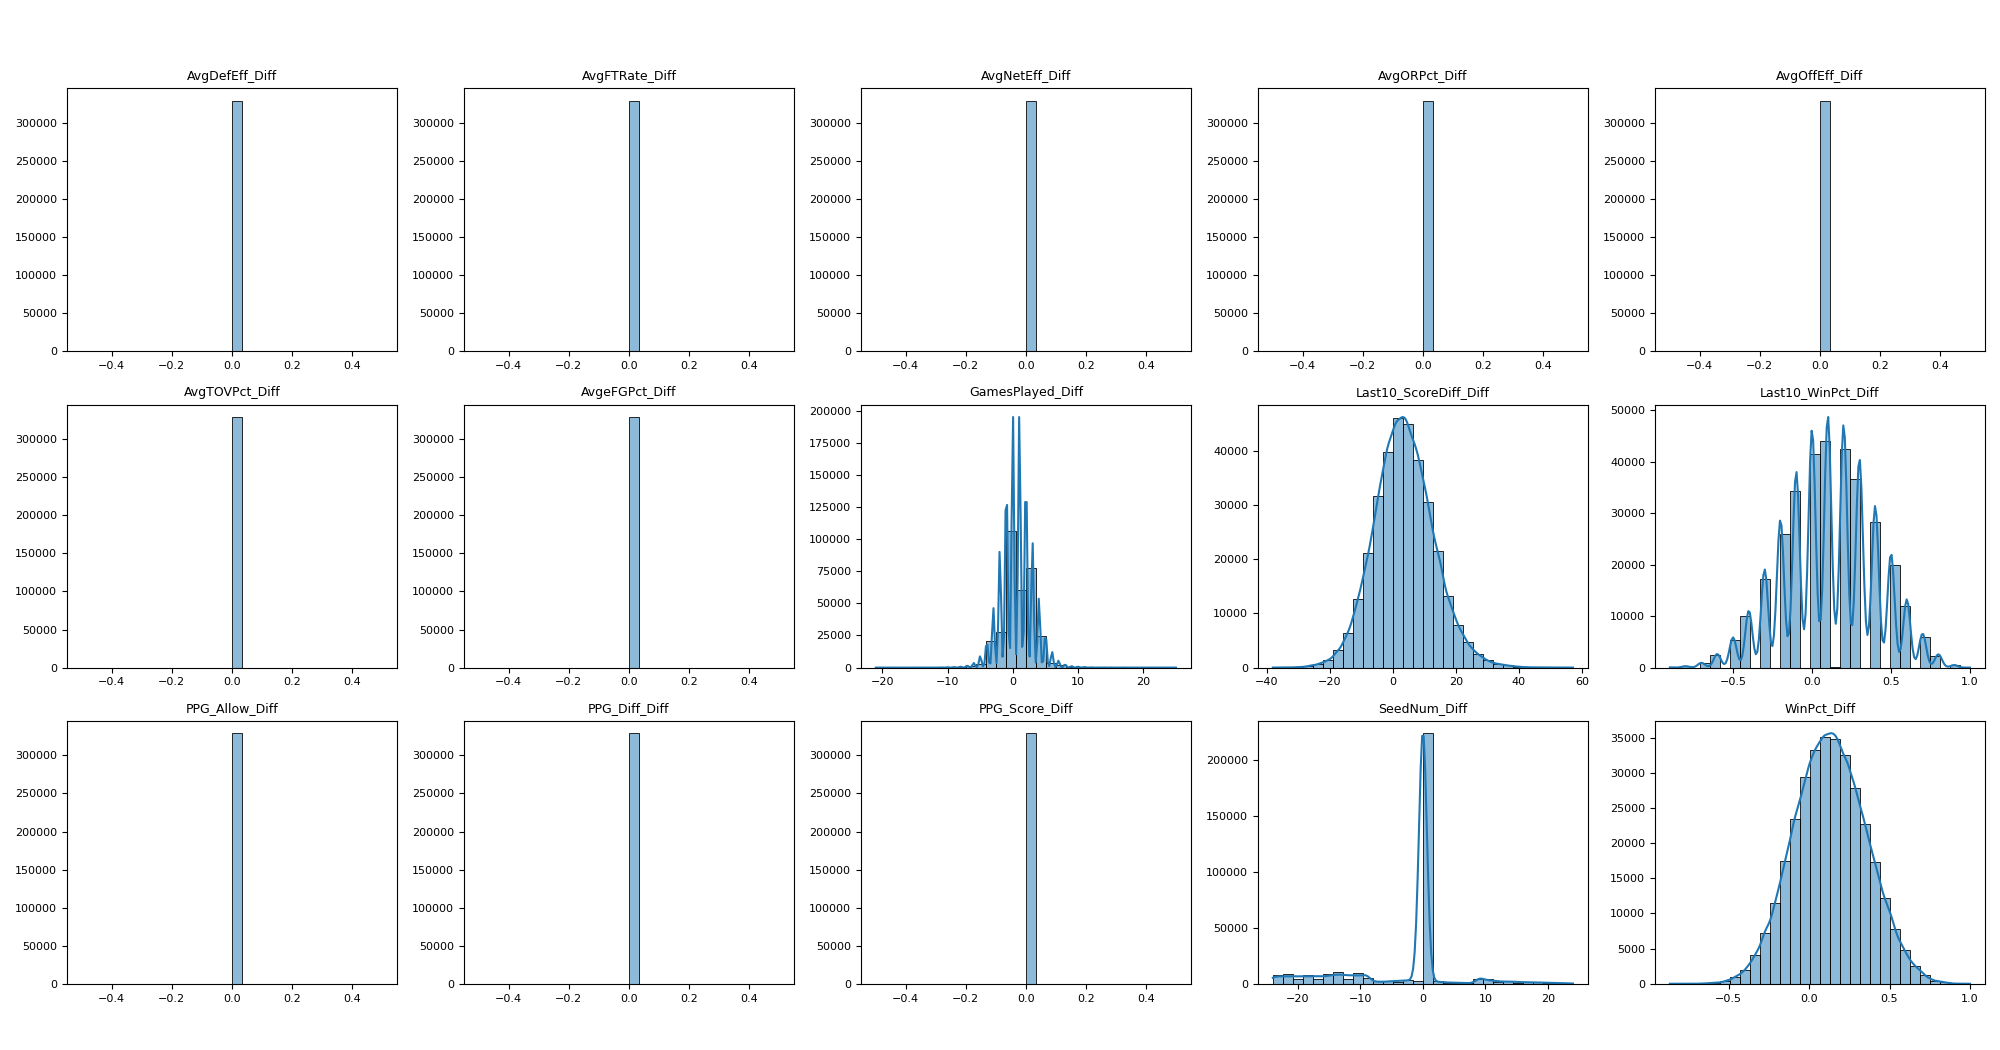

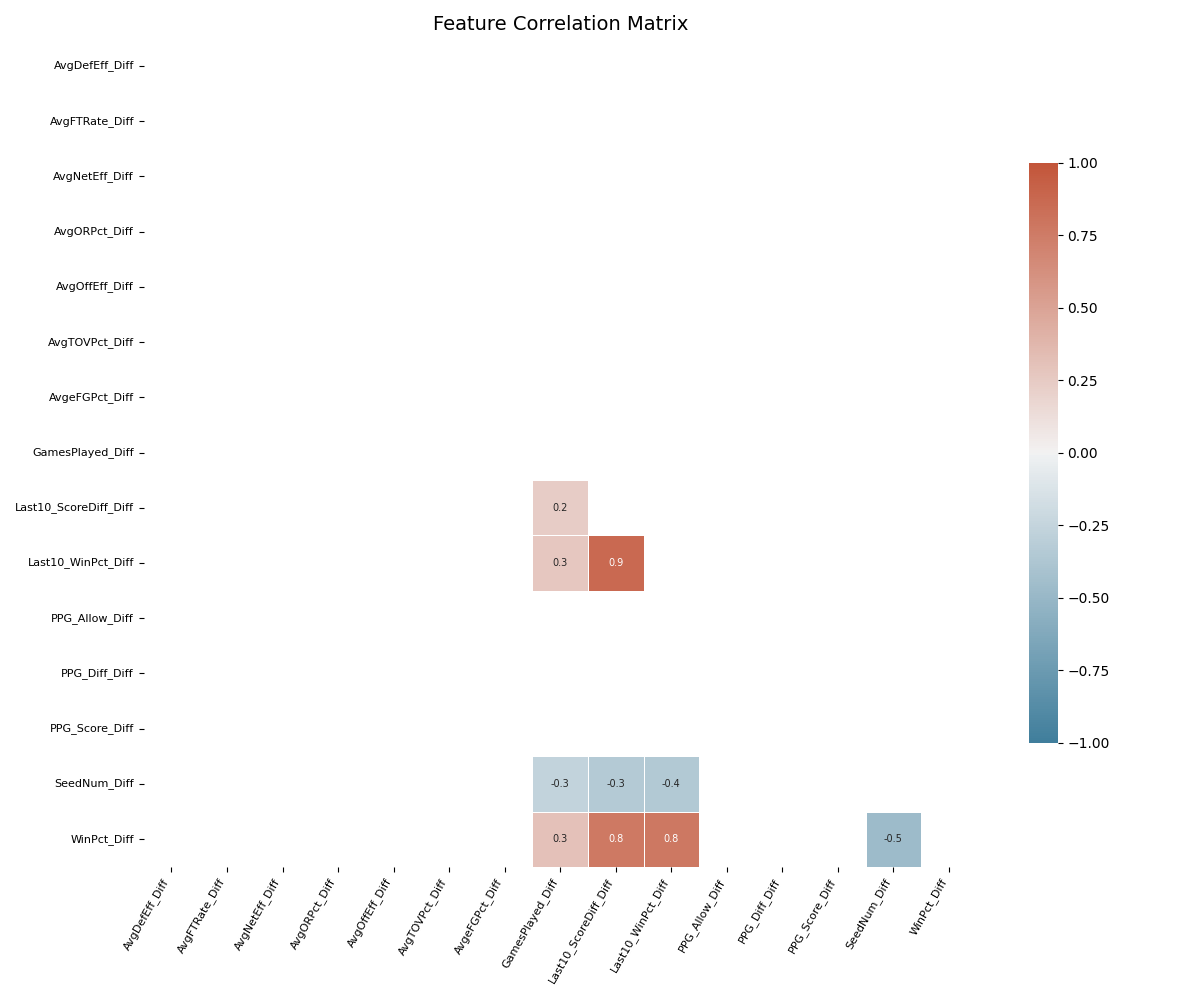


Feature Correlation Matrix:


In [4]:
# === Stage 3: Pre-Training Visualization (Kaggle) ===
import time
import pandas as pd
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import seaborn as sns # Ensure seaborn is imported
if config_imported: # Check dependencies
    from src.visualize import plot_feature_distributions, plot_correlation_matrix # Import plotting functions
    from src.utils import logger
    # Define the training data file path using the (potentially overridden) config
    train_data_path = config.TRAIN_DATA_FILE

    logger.info("\n===== Stage 3: Pre-Training Visualization (Kaggle) =====")
    stage_start = time.time()

    # Check if train_data and train_features exist from previous cell
    # Otherwise, load the training data file
    if 'train_data' not in locals() or 'train_features' not in locals() or train_data.empty or not train_features:
        logger.info(f"Loading training data from {train_data_path} for visualization...")
        if train_data_path.exists():
            try:
                train_data = pd.read_parquet(train_data_path)
                # Re-identify feature names if loading from file
                train_features = sorted([col for col in train_data.columns if col.endswith('_Diff')])
                if not train_features:
                    logger.error("Loaded training data but found no '*_Diff' feature columns.")
                    train_data = pd.DataFrame() # Mark as empty if features missing
            except Exception as e:
                logger.error(f"Failed to load training data from {train_data_path}: {e}")
                train_data = pd.DataFrame() # Mark as empty on error
        else:
            logger.error(f"Training data file not found at {train_data_path}. Cannot generate pre-training plots.")
            train_data = pd.DataFrame() # Mark as empty if file missing

    # Proceed only if we have data and features
    if not train_data.empty and train_features:
        try:
            logger.info("Generating feature distribution plot...")
            # Pass the specific save path within the Kaggle working directory
            plot_feature_distributions(
                train_data,
                train_features,
                save_path=config.VIZ_PATH / "feature_distributions.png"
            )
            print(f"Distribution plot saved to {config.VIZ_PATH / 'feature_distributions.png'}")

            logger.info("Generating feature correlation matrix...")
            plot_correlation_matrix(
                train_data,
                train_features,
                save_path=config.VIZ_PATH / "correlation_matrix.png"
            )
            print(f"Correlation plot saved to {config.VIZ_PATH / 'correlation_matrix.png'}")

            # --- Display Plots Directly in Notebook Output ---
            print("\n--- Pre-Training Feature Plots ---")
            from IPython.display import Image, display

            dist_img_path = config.VIZ_PATH / "feature_distributions.png"
            if dist_img_path.exists():
                print("Feature Distributions:")
                display(Image(filename=str(dist_img_path), width=800)) # Adjust width if needed
            else:
                print("Distribution plot image not found.")

            corr_img_path = config.VIZ_PATH / "correlation_matrix.png"
            if corr_img_path.exists():
                print("\nFeature Correlation Matrix:")
                display(Image(filename=str(corr_img_path), width=800)) # Adjust width if needed
            else:
                print("Correlation plot image not found.")
            # ----------------------------------------------------

        except Exception as e:
            logger.error(f"Error during pre-training visualization: {e}", exc_info=True)
    else:
        logger.warning("Skipping pre-training visualization as training data or features are unavailable.")


    logger.info(f"Stage 3 completed in {time.time() - stage_start:.2f} seconds.")
else:
    print("Skipping Stage 3 due to setup errors.")

## 4. Model Training & Evaluation

**Model:** A Sequential Neural Network built with TensorFlow/Keras.
*   Architecture: Input -> Dense(256, ReLU) -> BN -> Dropout(0.4) -> Dense(128, ReLU) -> BN -> Dropout(0.4) -> Dense(64, ReLU) -> BN -> Dropout(0.4) -> Dense(1, Sigmoid). *(Adjust if you change TF_PARAMS)*
*   Optimizer: Adam (LR=0.0005). *(Adjust if you change TF_PARAMS)*
*   Loss: Custom Brier Score (`brier_score_tf`).
*   Regularization: L2 (0.0005). *(Adjust if you change TF_PARAMS)*

**Validation Strategy:** 5-Fold GroupKFold, grouped by `Season`.
*   This prevents leakage by ensuring that games from the same season are entirely in either the training *or* the validation set for each fold, providing a more realistic performance estimate.

**Callbacks:** EarlyStopping (monitor `val_brier_score_tf`, patience=15), ReduceLROnPlateau, ModelCheckpoint (saving best model per fold).

**Out-of-Fold (OOF) Results:**
*   **OOF Brier Score:** [**PASTE YOUR SCORE HERE, e.g., 0.25123**]
    *   *(Lower is better. 0.25 is a starting point. Scores < 0.20 are decent, < 0.18 good, < 0.15 competitive).*
*   **OOF Log Loss:** [**Paste Log Loss from logs here**]

*(Optional: Add the OOF plot generation/embedding code here from Cell 11 below if preferred)*

In [5]:
# === Stage 4: Model Training ===
import time
if config_imported and 'train_features' in locals(): # Check dependencies
    from src.models import train_evaluate_tf
    from src.utils import logger

    logger.info("\n===== Stage 4: Model Training (Kaggle) =====")
    stage_start = time.time()
    # train_evaluate_tf uses config variables for paths/params by default
    oof_preds, scaler, features_from_train = train_evaluate_tf()
    if oof_preds is None:
        logger.error("STOPPING: Model training failed.")
        assert False, "Model training failed."
    else:
        logger.info(f"Stage 4 completed in {time.time() - stage_start:.2f} seconds.")
        # Keep scaler and features_from_train for prediction stage
        gc.collect()
else:
    print("Skipping Stage 4 due to setup errors or missing features.")

Epoch 1/150
256/256 - 10s - 40ms/step - AUC: 0.5001 - brier_score_tf: 0.2882 - loss: 0.4061 - val_AUC: 0.5000 - val_brier_score_tf: 0.2506 - val_loss: 0.3481 - learning_rate: 5.0000e-04
Epoch 2/150
256/256 - 1s - 3ms/step - AUC: 0.5012 - brier_score_tf: 0.2622 - loss: 0.3435 - val_AUC: 0.5000 - val_brier_score_tf: 0.2502 - val_loss: 0.3168 - learning_rate: 5.0000e-04
Epoch 3/150
256/256 - 1s - 3ms/step - AUC: 0.5001 - brier_score_tf: 0.2558 - loss: 0.3099 - val_AUC: 0.5000 - val_brier_score_tf: 0.2501 - val_loss: 0.2929 - learning_rate: 5.0000e-04
Epoch 4/150
256/256 - 1s - 3ms/step - AUC: 0.4985 - brier_score_tf: 0.2531 - loss: 0.2871 - val_AUC: 0.5000 - val_brier_score_tf: 0.2500 - val_loss: 0.2760 - learning_rate: 5.0000e-04
Epoch 5/150
256/256 - 1s - 3ms/step - AUC: 0.5002 - brier_score_tf: 0.2515 - loss: 0.2718 - val_AUC: 0.5000 - val_brier_score_tf: 0.2500 - val_loss: 0.2652 - learning_rate: 5.0000e-04
Epoch 6/150
256/256 - 1s - 3ms/step - AUC: 0.4993 - brier_score_tf: 0.2505 - l

Epoch 1/150
260/260 - 9s - 36ms/step - AUC: 0.5023 - brier_score_tf: 0.2879 - loss: 0.4057 - val_AUC: 0.5000 - val_brier_score_tf: 0.2506 - val_loss: 0.3475 - learning_rate: 5.0000e-04
Epoch 2/150
260/260 - 1s - 3ms/step - AUC: 0.4983 - brier_score_tf: 0.2626 - loss: 0.3427 - val_AUC: 0.5000 - val_brier_score_tf: 0.2502 - val_loss: 0.3148 - learning_rate: 5.0000e-04
Epoch 3/150
260/260 - 1s - 2ms/step - AUC: 0.5004 - brier_score_tf: 0.2552 - loss: 0.3069 - val_AUC: 0.5000 - val_brier_score_tf: 0.2503 - val_loss: 0.2905 - learning_rate: 5.0000e-04
Epoch 4/150
260/260 - 1s - 3ms/step - AUC: 0.4990 - brier_score_tf: 0.2529 - loss: 0.2842 - val_AUC: 0.5000 - val_brier_score_tf: 0.2501 - val_loss: 0.2737 - learning_rate: 5.0000e-04
Epoch 5/150
260/260 - 1s - 2ms/step - AUC: 0.5000 - brier_score_tf: 0.2513 - loss: 0.2693 - val_AUC: 0.5000 - val_brier_score_tf: 0.2501 - val_loss: 0.2634 - learning_rate: 5.0000e-04
Epoch 6/150
260/260 - 1s - 3ms/step - AUC: 0.4985 - brier_score_tf: 0.2505 - lo

Epoch 1/150
255/255 - 10s - 37ms/step - AUC: 0.4998 - brier_score_tf: 0.2888 - loss: 0.4070 - val_AUC: 0.5000 - val_brier_score_tf: 0.2508 - val_loss: 0.3485 - learning_rate: 5.0000e-04
Epoch 2/150
255/255 - 1s - 3ms/step - AUC: 0.4983 - brier_score_tf: 0.2624 - loss: 0.3437 - val_AUC: 0.5000 - val_brier_score_tf: 0.2501 - val_loss: 0.3162 - learning_rate: 5.0000e-04
Epoch 3/150
255/255 - 1s - 3ms/step - AUC: 0.4983 - brier_score_tf: 0.2553 - loss: 0.3087 - val_AUC: 0.5000 - val_brier_score_tf: 0.2501 - val_loss: 0.2920 - learning_rate: 5.0000e-04
Epoch 4/150
255/255 - 1s - 2ms/step - AUC: 0.5006 - brier_score_tf: 0.2528 - loss: 0.2857 - val_AUC: 0.5000 - val_brier_score_tf: 0.2501 - val_loss: 0.2752 - learning_rate: 5.0000e-04
Epoch 5/150
255/255 - 1s - 3ms/step - AUC: 0.5021 - brier_score_tf: 0.2512 - loss: 0.2705 - val_AUC: 0.5000 - val_brier_score_tf: 0.2501 - val_loss: 0.2645 - learning_rate: 5.0000e-04
Epoch 6/150
255/255 - 1s - 3ms/step - AUC: 0.5000 - brier_score_tf: 0.2505 - l

Epoch 1/150
255/255 - 10s - 38ms/step - AUC: 0.4998 - brier_score_tf: 0.2889 - loss: 0.4069 - val_AUC: 0.5000 - val_brier_score_tf: 0.2508 - val_loss: 0.3483 - learning_rate: 5.0000e-04
Epoch 2/150
255/255 - 1s - 3ms/step - AUC: 0.5005 - brier_score_tf: 0.2619 - loss: 0.3431 - val_AUC: 0.5000 - val_brier_score_tf: 0.2501 - val_loss: 0.3161 - learning_rate: 5.0000e-04
Epoch 3/150
255/255 - 1s - 3ms/step - AUC: 0.5005 - brier_score_tf: 0.2554 - loss: 0.3087 - val_AUC: 0.5000 - val_brier_score_tf: 0.2500 - val_loss: 0.2917 - learning_rate: 5.0000e-04
Epoch 4/150
255/255 - 1s - 3ms/step - AUC: 0.4987 - brier_score_tf: 0.2532 - loss: 0.2859 - val_AUC: 0.5000 - val_brier_score_tf: 0.2500 - val_loss: 0.2748 - learning_rate: 5.0000e-04
Epoch 5/150
255/255 - 1s - 3ms/step - AUC: 0.4985 - brier_score_tf: 0.2513 - loss: 0.2704 - val_AUC: 0.5000 - val_brier_score_tf: 0.2500 - val_loss: 0.2642 - learning_rate: 5.0000e-04
Epoch 6/150
255/255 - 1s - 3ms/step - AUC: 0.4999 - brier_score_tf: 0.2505 - l

Epoch 1/150
262/262 - 10s - 37ms/step - AUC: 0.4990 - brier_score_tf: 0.2888 - loss: 0.4064 - val_AUC: 0.5000 - val_brier_score_tf: 0.2506 - val_loss: 0.3474 - learning_rate: 5.0000e-04
Epoch 2/150
262/262 - 1s - 3ms/step - AUC: 0.4980 - brier_score_tf: 0.2630 - loss: 0.3430 - val_AUC: 0.5000 - val_brier_score_tf: 0.2502 - val_loss: 0.3148 - learning_rate: 5.0000e-04
Epoch 3/150
262/262 - 1s - 3ms/step - AUC: 0.4998 - brier_score_tf: 0.2548 - loss: 0.3066 - val_AUC: 0.5000 - val_brier_score_tf: 0.2500 - val_loss: 0.2903 - learning_rate: 5.0000e-04
Epoch 4/150
262/262 - 1s - 2ms/step - AUC: 0.5012 - brier_score_tf: 0.2521 - loss: 0.2835 - val_AUC: 0.5000 - val_brier_score_tf: 0.2500 - val_loss: 0.2737 - learning_rate: 5.0000e-04
Epoch 5/150
262/262 - 1s - 2ms/step - AUC: 0.5013 - brier_score_tf: 0.2507 - loss: 0.2688 - val_AUC: 0.5000 - val_brier_score_tf: 0.2500 - val_loss: 0.2633 - learning_rate: 5.0000e-04
Epoch 6/150
262/262 - 1s - 3ms/step - AUC: 0.5010 - brier_score_tf: 0.2503 - l

Calibration plot saved to /kaggle/working/visualizations/oof_calibration_curve.png
Distribution plot saved to /kaggle/working/visualizations/oof_prediction_distribution.png

--- OOF Plots ---
OOF Calibration Curve:


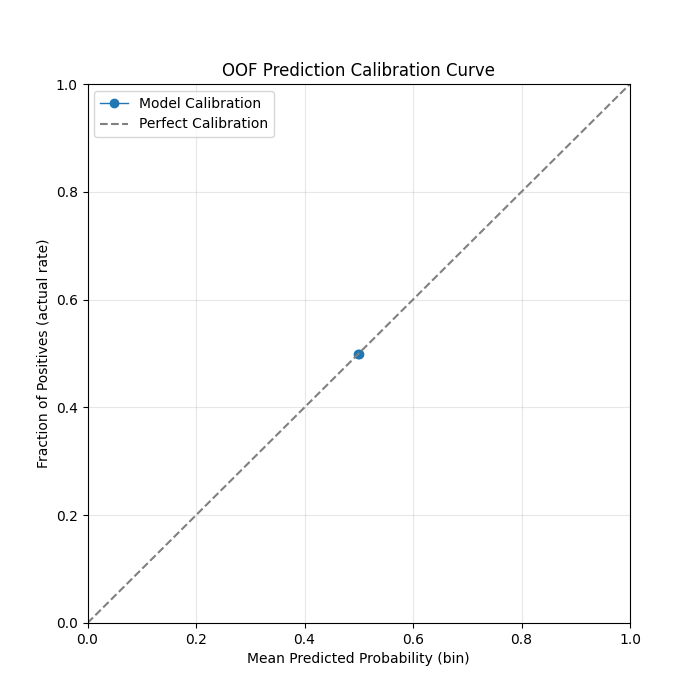


OOF Prediction Distribution:


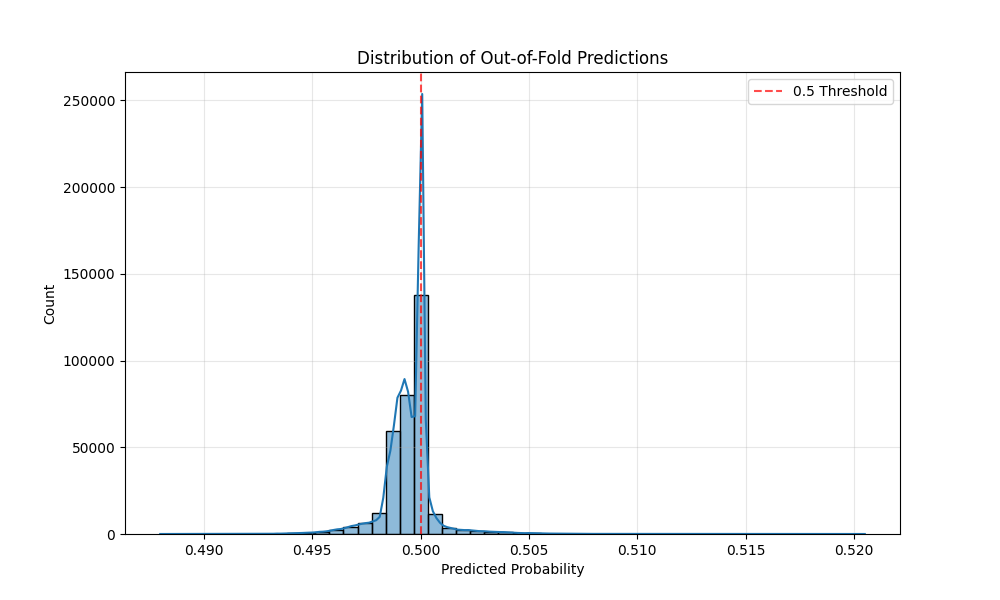

In [6]:
# === Stage 5: Post-Training Visualization (Kaggle) ===
import time
import pandas as pd
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import seaborn as sns # Ensure seaborn is imported
if config_imported: # Check dependencies
    from src.visualize import plot_oof_calibration, plot_oof_distribution # Import plotting functions
    from src.utils import logger
    # Define the OOF file path using the (potentially overridden) config
    oof_file_path = config.OOF_PREDS_FILE

    logger.info("\n===== Stage 5: Post-Training Visualization (Kaggle) =====")
    stage_start = time.time()

    if oof_file_path.exists():
        try:
            logger.info(f"Loading OOF predictions from: {oof_file_path}")
            oof_df = pd.read_csv(oof_file_path)

            if not oof_df.empty:
                logger.info("Generating OOF calibration plot...")
                # Pass the specific save path within the Kaggle working directory
                plot_oof_calibration(oof_df, save_path=config.VIZ_PATH / "oof_calibration_curve.png")
                print(f"Calibration plot saved to {config.VIZ_PATH / 'oof_calibration_curve.png'}")

                logger.info("Generating OOF prediction distribution plot...")
                plot_oof_distribution(oof_df, save_path=config.VIZ_PATH / "oof_prediction_distribution.png")
                print(f"Distribution plot saved to {config.VIZ_PATH / 'oof_prediction_distribution.png'}")

                # --- Display Plots Directly in Notebook Output ---
                print("\n--- OOF Plots ---")
                from IPython.display import Image, display

                cal_img_path = config.VIZ_PATH / "oof_calibration_curve.png"
                if cal_img_path.exists():
                    print("OOF Calibration Curve:")
                    display(Image(filename=str(cal_img_path))) # Display the saved image
                else:
                    print("Calibration plot image not found.")

                dist_img_path = config.VIZ_PATH / "oof_prediction_distribution.png"
                if dist_img_path.exists():
                    print("\nOOF Prediction Distribution:")
                    display(Image(filename=str(dist_img_path))) # Display the saved image
                else:
                    print("Distribution plot image not found.")
                # ----------------------------------------------------

            else:
                logger.warning("OOF predictions file is empty, skipping plots.")

        except FileNotFoundError:
            logger.warning(f"OOF predictions file not found at {oof_file_path}, skipping OOF visualization.")
        except Exception as e:
            logger.error(f"Error during post-training visualization: {e}", exc_info=True)
    else:
        logger.warning(f"OOF predictions file not found at {oof_file_path}, skipping OOF visualization.")

    logger.info(f"Stage 5 completed in {time.time() - stage_start:.2f} seconds.")
else:
    print("Skipping Stage 5 due to setup errors.")

## 6. Submission Generation

The final step generates predictions for all possible `YYYY_Team1ID_Team2ID` matchups for the `CURRENT_SEASON` (2025) using the average prediction across the 5 trained fold models. The predictions are clipped between 0.01 and 0.99.

*(Show submission_df.head() output here)*

```python
# Example code to show head in notebook cell
# import pandas as pd
# from config import SUBMISSIONS_DIR, FINAL_SUBMISSION_FILE
# sub_df = pd.read_csv(SUBMISSIONS_DIR / FINAL_SUBMISSION_FILE)
# print(sub_df.head())

In [7]:
# === Stage 6: Generate Predictions ===
import time
if config_imported and 'features_from_train' in locals(): # Check dependencies
    from src.submit import generate_tf_predictions
    from src.utils import logger

    logger.info("\n===== Stage 6: Generate Final Predictions (Kaggle) =====")
    stage_start = time.time()
    # generate_tf_predictions uses config variables for paths/params by default
    submission_df = generate_tf_predictions()
    if submission_df is None:
        logger.error("STOPPING: Prediction generation failed.")
        assert False, "Prediction generation failed."
    else:
        logger.info(f"Stage 6 completed in {time.time() - stage_start:.2f} seconds.")
        print("\n--- Submission File Head (Kaggle Run) ---")
        print(submission_df.head())
        print(f"Submission file shape: {submission_df.shape}")
        print(f"Submission file saved to: {config.SUBMISSIONS_DIR / config.FINAL_SUBMISSION_FILE}")
else:
    print("Skipping Stage 6 due to setup errors or incomplete training.")

Predicting Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- Submission File Head (Kaggle Run) ---
                   ID      Pred
0  2025_1101.0_1102.0  0.499830
1  2025_1101.0_1103.0  0.500081
2  2025_1101.0_1104.0  0.501088
3  2025_1101.0_1105.0  0.499550
4  2025_1101.0_1106.0  0.500106
Submission file shape: (131407, 2)
Submission file saved to: /kaggle/working/submissions/2025_submission_kaggle.csv
